# Channel simulation and channel prediction

In this notebook we simulate a **realistic LTE channel** (in Part 1) and we perform channel prediction on the basis of the channel history, by applying **Wiener filtering** (in Part 2). 

**Note**: in order to run Part 2 of the notebook, the user needs to run Part 1 first. We recommend to run the computation cells of the notebook in the order they appear.

In [1]:
# Basic imports
import itpp
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import special
import tabulate as tab
from mpl_toolkits.mplot3d import Axes3D

#Flag used to choose if the user wants to save the plots generated in the notebook
savefig = False


# Part 1 - Channel simulation

In Part 1 of this notebook we simulate a realistic LTE link chain, using the [py-itpp library](http://itpp.sourceforge.net/4.3.1/). In particular we set up a fading channel using the stochastic tapped delay line [(TDL) channel models](http://itpp.sourceforge.net/4.3.1/classitpp_1_1TDL__Channel.html) that are supported by py-itpp.
In case of TDL channels, the channel impulse response (CIR) is modeled as several time-delayed 'taps', where each tap is a random variable with a defined delay $\tau$. Therefore, the channel response is given by <a id='eq1'></a>
$$h(t,\tau) = \sum_{n=1}^{N}c_n(\tau)\delta(t-\tau_n)\;\;\; (1) $$ 
where $N$ is the number of taps.
The reader can select one of the TDL channel profiles supported by py-itpp, as listed in Table 1. 

| Supported channel profiles|       
| ------------- |
| ITU_Vehicular_A      | 
| ITU_Vehicular_B    | 
| ITU_Pedestrian_A| 
|ITU_Pedestrian_B|
|COST207_RA|
|COST207_RA6|
|COST207_TU|
|COST207_TU6alt|
|COST207_TU12|
|COST207_TU12alt|
|COST207_HT|
|COST207_HT6alt|
|COST207_HT12|
|COST207_HT12alt|
|COST259_TUx|
|COST259_RAx|
|COST259_RAx|
Table 1. Supported channel profiles by py-itpp


## Radio link parameters

We now define the radio link parameters related to the LTE channel. We suggest to the reader to keep all the parameters fixed, apart from `relative_speed`[m/s], which can let the reader appreciate the channel variations according to the speed of the mobile user. 

**Note**: make sure that the value selected for `relative_speed` is coherent with the selected channel profile in `channel_spec`.
For instance, if `relative_speed = 40`[m/s], then the selected channel profile should not be of `PEDESTRIAN` type.
<span style="color:red">

In [2]:
# Speed of the mobile user, assuming that the base staion is stationary
relative_speed = 20 # [m/s]
# Specify the channel profile. Any on the channel profiles in Table 1 can be selected
channel_spec = itpp.comm.Channel_Specification(itpp.comm.CHANNEL_PROFILE.ITU_Vehicular_B)
# Transmission bandwidth and duration
nrof_subcarriers = 72
# Sampling frequency and interval
subcarrier_spacing = 15000 # [Hz]
# FFT size for the OFDM channel. Chosen to the closest power of 2 greater than the 'nrof_subcarriers'
fft_size = 128# 
sampling_frequency = subcarrier_spacing * fft_size 
sampling_interval = 1.0 / sampling_frequency # [s]
carrier_frequency = 2e9 # [Hz]
speed_of_light = 3e8 # [m/s]
transmission_duration = 71.4e-6 #[s]
transmission_interval = 1e-3 #[s]
cyclic_prefix_length=102
# Define number of channel samples to generate 
nrof_channel_samples = 500
# Flag that determines whether the cannel samples should be noisy
noise_flag=True
# Signal to noise ratio over transmission bandwidth
snr_dB = 1
noise_variance = itpp.math.inv_dB(-snr_dB)  # Normalizing the received power to 1 (=0 dB) 
# Create the channel model
channel = itpp.comm.TDL_Channel(channel_spec, sampling_interval)
# Maximum Doppler frequency 
doppler_frequency = (carrier_frequency / speed_of_light) * relative_speed
#Normalized channel doppler
norm_doppler = doppler_frequency * sampling_interval
# Set the normalized channel Doppler
channel.set_norm_doppler(norm_doppler)


## Generate the channel impulse response (CIR) and the channel frequency response (CFR)

Here we generate some samples of the channel impulse response (CIR). For each time instant, the CIR is a vector of size `fft_size`. Then we convert the CIR to frequency domain, by taking the Fourier transform, and we obtain the channel frequency response (CFR). The size of the CFR vector is `fft_size`. Howevere, we can keep only the first `nrof_subcarrier` samples of the CFR and discard the rest since we only have `nrof_subcarrier` subcarriers.

In [3]:
# Placeholder to store channel impulse responses
nrof_taps = channel.taps()
channel_impulse_response = itpp.cmat(nrof_taps, nrof_channel_samples) 
channel_frequency_response = itpp.cmat(nrof_subcarriers, nrof_channel_samples)
# Generate channel samples. Each channel sample is shifted by the transmission interval
sample_channel_coeff = itpp.cmat()

for sample_index in range(nrof_channel_samples):
    
    channel.set_time_offset(sample_index * int(transmission_interval / sampling_interval))
    # Generate a single channel sample with current time offset
    channel.generate(1, sample_channel_coeff) 
    channel_impulse_response.set_col(sample_index, sample_channel_coeff.get_row(0))
    # Obtain the channel frequency response by taking FFT of channel impulse response.
    # The FFT size is 2^n for computation speed, from which we extract nrof_subcarrier values.
    channel_impuse_fft = itpp.signal.fft(channel_impulse_response.get_col(sample_index), fft_size)
    channel_frequency_response.set_col(sample_index, channel_impuse_fft.left(nrof_subcarriers))
    
# The channel frequency response and the channel frequency data are stored into numpy arrays for ease of processing 
channel_freq_data = channel_frequency_response.to_numpy_ndarray()
channel_impulse_response_data = channel_impulse_response.to_numpy_ndarray()

# Here noise is added to the channel frequency response
if noise_flag == True:
    # Complex noise is created and added to the channel frequency response
    complex_noise = (np.random.randn(channel_freq_data.shape[0],channel_freq_data.shape[1])*np.sqrt(noise_variance/2)+1j*np.random.randn(channel_freq_data.shape[0],channel_freq_data.shape[1])*np.sqrt(noise_variance/2))
    channel_freq_data_noisy = channel_freq_data + complex_noise
    # We add zeros in order to reach the FFT size
    channel_freq_data_noisy_zeros_added = np.append(channel_freq_data_noisy,np.zeros([(fft_size-nrof_subcarriers),channel_freq_data.shape[1]]),axis=0)


## Visualize the channel

Here below the magnitude of the channel frequency response is visualized. The reader can appreciate the frequency selectivity of the channel. In our set up we assume that the channel is block fading, i.e. the channel reman constant during each samling interval.

Text(0.5, 0, 'Channel Magnitude')

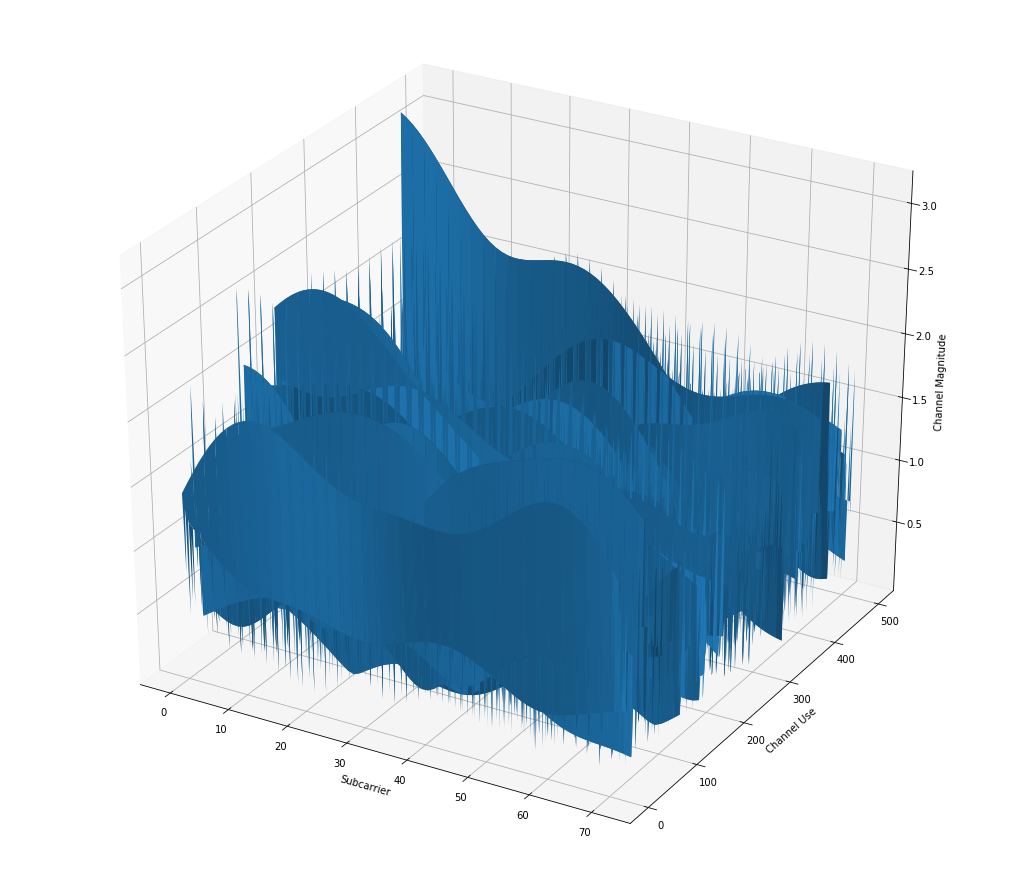

In [4]:
channel_magnitude = itpp.math.abs(channel_frequency_response)

plt.figure(figsize =(18, 16))
Z = channel_magnitude.get_cols(0, nrof_channel_samples-1).to_numpy_ndarray()
x = np.arange(0, nrof_subcarriers)
y = np.arange(0, nrof_channel_samples)
X, Y = np.meshgrid(x, y)

plt.gca(projection ='3d').plot_surface(X, Y, np.transpose(Z))
plt.gca().set_xlabel('Subcarrier')
plt.gca().set_ylabel('Channel Use')
plt.gca().set_zlabel('Channel Magnitude')

# Part 2 - Channel prediction

In Part 2 of the notebook we focus on channel prediction. Assuming that the channel gains evolve as a Gaussian process, the FIR Wiener filter is the minimum mean squared error (MMSE) estimator. 
The coefficients of FIR Wiener filter can be computed by solving Wiener-Hopf equation (eq. (12.65) from [[1]](#ref)). Such coefficients depend on the autocorrelation and crosscorrelation function of the channel, which , according to jakes' scattering model ([[2]](#ref)) is given by the zero-order bessel function of the first kind, i.e., $$J_{0}(2\pi f_{d}\tau),$$
where $f_{d}$ is the maximum doppler frequency.  .
Finally we assess the performance of our predictor by computing the mean squared error (MSE) between the predicted channel and the actual channel. We also quantify the benefit of channel prediction by comparing the Wiener filter-based MSE with the MSE computed in case no channel prediction. In the latter case the channel that we use is a delayed copy of the actual channel. 



## Utility functions and Wiener filter implementation 

In [5]:
# This function implements the theoretical autocorrelation function, i.e. Bessel
def autocorrelation(m,f_d,T_s):
  
  bessel_function_zero_order_first_kind = scipy.special.j0(2*np.pi*f_d*m*T_s)
  return bessel_function_zero_order_first_kind
################################################################################
# This function generates an upper-triangular matrix; useful when computing the
# Wiener coefficients
def create_upper_matrix(values, size):
    
    upper = np.zeros((size, size))
    upper[np.triu_indices(size, 0)] = values
    return(upper)
################################################################################  
# This function generates a lower-triangular matrix; useful when computing the
# Wiener coefficients
def create_lower_matrix(values, size):
    
    lower = np.zeros((size, size))
    lower[np.tril_indices(size, 0)] = values
    return(lower)
################################################################################

# This function computes the Wiener coefficients
def Wiener_filter_coeff_scaled(autocorrelation_of_reference,crosscorrelation,delta,snr,noise):
    
    b = autocorrelation_of_reference
    for i in range(1,len(autocorrelation_of_reference)):
        b = np.concatenate((b,autocorrelation_of_reference[:-i]))
        
    upper_half = create_upper_matrix(np.conj(b), len(autocorrelation_of_reference))
    lower_half = create_lower_matrix(np.flip(b,axis = 0), len(autocorrelation_of_reference))
    T = lower_half + upper_half

  
    for i in range(0, len(autocorrelation_of_reference)):
        
        if noise == True:
        
            T[i,i] = autocorrelation_of_reference[0]* ( 1 + snr) / snr
        
        else:
        
            T[i,i] = autocorrelation_of_reference[0]
       
    if noise == True and delta == 0:
        crosscorrelation[0] = crosscorrelation[0]*(( 1 + snr) / snr)
    
    v = np.transpose( crosscorrelation )
    a = np.conj(np.dot(np.linalg.inv(T),v))
  
    return a


In the following code apply Wiener filter to each channel subcarrier.
The user can select and play around with the following parameters:

|Parameter| Meaning |
|---------|:--------|
|`N`|Number of Wiener filter taps|
|`delta`|Number of channel samples that we predict ahead|


Note that the number of filter taps corresponds to the number of past channel samples that we use to perform the prediction. Also, the number of channel samples that we predict ahead correspond to a time interval. Such time interval depends on the channel sampling interal. In our set up we are sampling the channel every transmission interval because we assume we have a block fading channel. If `transmission_interval = 1e-3`, then `delta = 5` indicates that we predict the channel 5 ms ahead. 

Note that the quality of the prediction depends on the correlaton of the channel, which strictly depends on the mobile user velocity: if the user moves very fast, the channel will change very fast, and predictions far in time will become more difficult. The same reasoning applied to the SNR value. If the channel SNR increses then the accuracy of the prediction increases.

  Filter Taps    Channel samples we predict ahead     SNR [dB]
-------------  -----------------------------------  ----------
           10                                    1           1
  MSE with prediction [dB]    MSE no prediction [dB]
--------------------------  ------------------------
                0.00502811                 0.0042853


 Reduction of MSE [dB] thanks to channel prediction: -7.428175E-04 


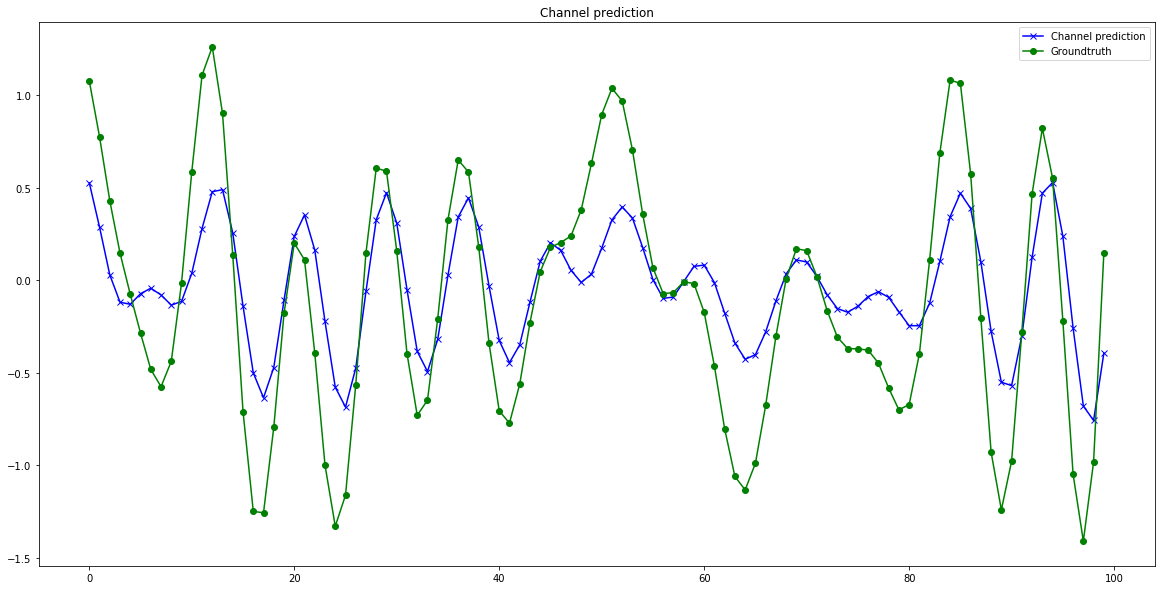

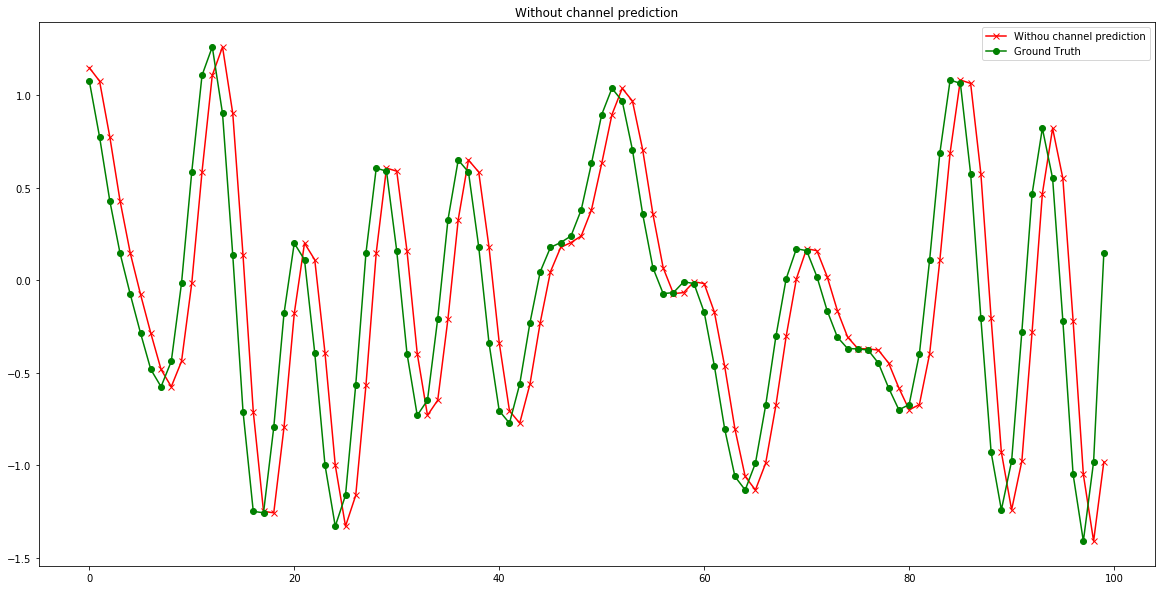

In [6]:
# How many channel samples are we predicting ahead?
delta = 1
# Number of Wiener filter taps
N = 10

snr = noise_variance  

# In this set-up we are sampling the channel every transmission interval because we assume we have a block fading channel    
channel_sampling_interval = transmission_interval

# Compute Wiener filter for a given velocity and carrier frequency
autocorrelation_of_reference = autocorrelation(np.arange(0,N,1),doppler_frequency,channel_sampling_interval)

crosscorrelation = autocorrelation(np.arange(delta,N+delta,1),doppler_frequency,channel_sampling_interval)

# Wiener filter coefficients
a = Wiener_filter_coeff_scaled(autocorrelation_of_reference,crosscorrelation,delta,snr, noise_flag)

# In order to asses the performance of the Wiener filter we compute the mean squared error between the actual channel and the predicted one
# We predict each of the nrof_subcarriers, we compute the MSE for each of them and we average the MSE over the nrof_subcarriers

# We quantify the benefit of channel prediction by computing the reduction of MSE that we have if we perform the prediction
# In case of no channel prediction that channel that we have is a "delta" shifted copy of the actual channel, i.e. we rae lagging behind by a "delta" shift in time
mean_squared_error_with_prediction = 0

mean_squared_error_no_prediction = 0

filter_output = []
for i in range(0, len(channel_freq_data)):
    
    h = channel_freq_data[i,:]
    
    h_ref = h[N+delta-1:]
    
    # Apply the Wiener filter
    filter_output_temp = np.convolve(a,h,"valid")
    
    if delta == 0:
        filter_output.append(filter_output_temp[:])
        mean_squared_error_with_prediction = mean_squared_error_with_prediction + (np.mean((np.absolute(channel_freq_data[i,N+delta-1:]-filter_output_temp[:]))**2)/len(channel_freq_data))
        mean_squared_error_no_prediction = mean_squared_error_no_prediction + (np.mean((np.absolute(channel_freq_data[i,N+delta-1:]-channel_freq_data[i,N-1:]))**2)/len(channel_freq_data))

    else:    
        filter_output.append(filter_output_temp[:-delta])
        mean_squared_error_with_prediction = mean_squared_error_with_prediction + (np.mean((np.absolute(channel_freq_data[i,N+delta-1:]-filter_output_temp[:-delta]))**2)/len(channel_freq_data))
        mean_squared_error_no_prediction = mean_squared_error_no_prediction + (np.mean((np.absolute(channel_freq_data[i,N+delta-1:]-channel_freq_data[i,N-1:-delta]))**2)/len(channel_freq_data))

    
    # When we have no prediction, then we are lagging behind by a "delta" shift in time
    

    
mean_squared_error_with_prediction = mean_squared_error_with_prediction/len(channel_freq_data)
mean_squared_error_no_prediction = mean_squared_error_no_prediction/len(channel_freq_data)

# In the following plots the real part of the channel is shown. The user can change np.real to np.imag to display the imaginary part of the channel

# Subcarrier that we want to display among the norf_subcarriers available
subcarrier_index = 0
# Number of channel samples of the selected subcarrier that we want to show
number_of_samples_to_show = 100

plt.figure( figsize = [20, 10]);
plt.title("Channel prediction")
plt.axis()
plt.plot(np.real(filter_output[subcarrier_index][:number_of_samples_to_show]),color = 'b',marker = 'x',label = "Channel prediction")
plt.plot(np.real(channel_freq_data[subcarrier_index,N + delta - 1:][:number_of_samples_to_show]),color = 'g',marker = 'o',label = "Groundtruth")
plt.legend()
if savefig == True:
    plt.savefig("Channel_prediction.png")

plt.figure( figsize = [20, 10]);
plt.title("Without channel prediction")
plt.plot(np.real(channel_freq_data[subcarrier_index,N - 1: - delta][:number_of_samples_to_show]),color = 'r',marker = 'x',label = "Withou channel prediction")
plt.plot(np.real(channel_freq_data[subcarrier_index,N + delta - 1:][:number_of_samples_to_show]),color = 'g',marker = 'o',label = "Ground Truth")
plt.legend()
if savefig == True:
    plt.savefig("Without_channel_prediction.png")

values1 = [N,delta,snr_dB]
headers1 = ['Filter Taps','Channel samples we predict ahead ','SNR [dB]']
print(tab.tabulate([values1],headers1))

values2 = [mean_squared_error_with_prediction,mean_squared_error_no_prediction,]
headers2 = ['MSE with prediction [dB]','MSE no prediction [dB]']
print(tab.tabulate([values2],headers2))
print("\n\n Reduction of MSE [dB] thanks to channel prediction: %E "%(mean_squared_error_no_prediction-mean_squared_error_with_prediction))


# References <a id='ref'></a>

[[1]](https://dl.acm.org/citation.cfm?id=151045) S. M. Kay, Fundamentals of Statistical Signal Processing: Detection
Theory. Englewood Cliffs, NJ: PTR Prentice-Hall, 1998.

[[2]](https://ieeexplore.ieee.org/document/1209292) Yahong Rosa Zheng and Chengshan Xiao, "Simulation models with correct statistical properties for Rayleigh fading channels," in IEEE Transactions on Communications, vol. 51, no. 6, pp. 920-928, June 2003.
doi: 10.1109/TCOMM.2003.813259